#Modelo de clasificación: Procesado completo + PCA + Logistic Regression

Aplicando los resultados favorables respecto a una descomposición PCA inicial de los datos procedemos ahora a estudiar como se comporta un modelo de regresión logistica, además que este servirá de base para estudiar las redes neuronales, ya que este algoritmo es la base de dichos modelos.

##Instrucciones Generales

Para poder ejecutar el procesamiento propuesto, es necesario cargar tanto los archivos de la competencia de kaggle como el archivo de categorización manual de programas por área de conocimiento.

Para cargar los archivos de la competencia se puede:

1. Descargar directamente desde la página de kaggle: https://www.kaggle.com/competitions/udea-ai-4-eng-20251-pruebas-saber-pro-colombia/data y luego cargar manualmente al entorno

2. O ejecutar las celdas de carga directa utilizando una api-key propia de kaggle (archivo kaggle.json) que se debe cargar al entorno

Finalmente se debe cargar el archivo Categorias.csv que se ha enlazado en el repositorio github de esta solución para poder aplicar el procesamiento

##Importaciones básicas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
%matplotlib inline

##Preprocesado de los datos

###Carga de los datos

In [ ]:
!mkdir /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.14GB/s]
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


###Creacion dataframe y su transformación

####Definición de las funciones de transformación

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  other_column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =['OTRO'])
  df_copy = df_copy.join(other_column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def assign_area(program):
    for area in programs.keys():
      if program in programs[area]:
        return area

    return 'OTRO'

  df_copy['AREA_TMP'] = df_copy['ESTU_PRGM_ACADEMICO'].apply(assign_area)

  for area in programs.keys():
      df_copy[area] = (df_copy['AREA_TMP'] == area).astype(int)

  df_copy['OTRO'] = (df_copy['AREA_TMP'] == 'OTRO').astype(int)
  df_copy = df_copy.drop(columns=['AREA_TMP'])

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy

In [ ]:
def process_data(df, programs_df):

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)
  df_copy = df_copy.drop(columns=['ESTU_PRGM_ACADEMICO'])

  return df_copy

####Dataframe resultante

In [ ]:
try:
  df = pd.read_csv("train.csv")
except:
  print("No se ha cargado el archivo train.csv al entorno")

In [ ]:
try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
    programs_df = programs_df.sample(frac=0.70, random_state=42)
    df = process_data(df, programs_df)
    print(df.shape)
except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

/tmp/ipython-input-6-3166745170.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(692500, 58)


###Separación de los datos

In [ ]:
X = df.drop(columns=['RENDIMIENTO_GLOBAL'])
y = df['RENDIMIENTO_GLOBAL']
print(X.shape)
print(y.shape)

(692500, 57)
(692500,)


##Creación y evaluacion del modelo

###Split de los datos de la muestra con train: 70% - test: 30%

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)

lr = LogisticRegression(class_weight='balanced', solver='newton-cholesky',penalty='l2')

###Modelo y calibración

In [ ]:
from sklearn.decomposition import PCA

n = Xtr.shape[1]
max_acc = 0
n_components = 4

for i in range(4,n,6):

  pca = PCA(n_components=i)
  pca.fit(Xtr)
  Xtr_pca = pca.transform(Xtr)
  Xts_pca = pca.transform(Xts)

  lr.fit(Xtr_pca,ytr)
  acc_tr = lr.score(Xtr_pca,ytr)
  acc_ts = lr.score(Xts_pca,yts)

  if acc_ts > max_acc:
    max_acc = acc_ts
    n_components = i

  print (f"model with a PCA decomposition into {i} components and logist regresion, train accuracy: {acc_tr:6f}, test accuracy: {acc_ts:6f}")


model with a PCA decomposition into 4 components and logist regresion, train accuracy: 0.350313, test accuracy: 0.349767
model with a PCA decomposition into 10 components and logist regresion, train accuracy: 0.363610, test accuracy: 0.363249
model with a PCA decomposition into 16 components and logist regresion, train accuracy: 0.372373, test accuracy: 0.371548
model with a PCA decomposition into 22 components and logist regresion, train accuracy: 0.375608, test accuracy: 0.374671
model with a PCA decomposition into 28 components and logist regresion, train accuracy: 0.377461, test accuracy: 0.377126
model with a PCA decomposition into 34 components and logist regresion, train accuracy: 0.379239, test accuracy: 0.379177
model with a PCA decomposition into 40 components and logist regresion, train accuracy: 0.381751, test accuracy: 0.381906
model with a PCA decomposition into 46 components and logist regresion, train accuracy: 0.383893, test accuracy: 0.383591
model with a PCA decompos

In [ ]:
max_acc = 0

for i in range(n_components-3,min(n_components+4, Xtr.shape[1])):

  pca = PCA(n_components=i)
  pca.fit(Xtr)
  Xtr_pca = pca.transform(Xtr)
  Xts_pca = pca.transform(Xts)
  lr.fit(Xtr_pca,ytr)

  acc_tr = lr.score(Xtr_pca,ytr)
  acc_ts = lr.score(Xts_pca,yts)

  if acc_ts > max_acc:
    max_acc = acc_ts
    n_components = i

  print(f"model with a PCA decomposition into {i} components and logist regresion, train accuracy: {acc_tr:6f}, test accuracy: {acc_ts:6f}")

print(f"Descomposición optima con {n_components}")

model with a PCA decomposition into 49 components and logist regresion, train accuracy: 0.384351, test accuracy: 0.383841
model with a PCA decomposition into 50 components and logist regresion, train accuracy: 0.384369, test accuracy: 0.383793
model with a PCA decomposition into 51 components and logist regresion, train accuracy: 0.384369, test accuracy: 0.383793
model with a PCA decomposition into 52 components and logist regresion, train accuracy: 0.384365, test accuracy: 0.383769
model with a PCA decomposition into 53 components and logist regresion, train accuracy: 0.384359, test accuracy: 0.383745
model with a PCA decomposition into 54 components and logist regresion, train accuracy: 0.384380, test accuracy: 0.383730
model with a PCA decomposition into 55 components and logist regresion, train accuracy: 0.384384, test accuracy: 0.383726
Descomposición optima con 49


In [ ]:
pca = PCA(n_components=n_components)
pca.fit(Xtr)
Xtr = pca.transform(Xtr)
Xts = pca.transform(Xts)

In [ ]:
lr.fit(Xtr,ytr)
print (f"model with train: {lr.score(Xtr, ytr)}, test: {lr.score(Xts, yts)}")

model with train: 0.38435069623517276, test: 0.38384115523465706


In [ ]:
y_pred = lr.predict(Xtr)
yts_pred = lr.predict(Xts)
print (f"model with train: {np.mean((y_pred == ytr).astype(int))}, test: {np.mean((yts_pred == yts).astype(int))}")

model with train: 0.38435069623517276, test: 0.38384115523465706


###Validación cruzada

In [ ]:
def bootstrap_score(X, y, test_size, iterations=5):
  trscores, tsscores = [], []
  for _ in range(iterations):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    pca = PCA(n_components=49)
    pca.fit(Xtr)
    Xtr = pca.transform(Xtr)
    Xts = pca.transform(Xts)
    lr = LogisticRegression(class_weight='balanced', solver='newton-cholesky',penalty='l2')
    lr.fit(Xtr,ytr)
    trscores.append(lr.score(Xtr, ytr))
    tsscores.append(lr.score(Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

def evaluate_model(df, test_size):
  sample_sizes = [int(i*df.shape[0]) for i in np.linspace(0.2, 1, 5)]
  tr_scores, ts_scores = [], []

  for sample_size in sample_sizes:
    X = df.sample(sample_size)
    y = X['RENDIMIENTO_GLOBAL']
    X = X.drop(columns=['RENDIMIENTO_GLOBAL'])
    tr_sc, ts_sc = bootstrap_score(X, y, test_size, iterations=3)
    tr_scores.append(tr_sc)
    ts_scores.append(ts_sc)

  return (tr_scores, ts_scores)

def plot_learning_curve(title, train_scores_mean, train_scores_std,
                        test_scores_mean, test_scores_std, ylim=None,
                        train_sizes=np.linspace(.2, 1.0, 5)):

    from matplotlib import pyplot as plt

    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="test score")

    plt.legend(loc="best")

def compute_and_plot_learning_curve(test_size, title="Logistic Regression"):

    learn_curve_data = evaluate_model(df, 0.3)
    tr_means = np.array([learn_curve_data[0][i][0] for i in range(len(learn_curve_data[0]))])
    tr_stds = np.array([learn_curve_data[0][i][1] for i in range(len(learn_curve_data[0]))])
    ts_means = np.array([learn_curve_data[1][i][0] for i in range(len(learn_curve_data[1]))])
    ts_stds = np.array([learn_curve_data[1][i][1] for i in range(len(learn_curve_data[1]))])

    sample_sizes = [int(i*df.shape[0]) for i in np.linspace(0.2, 1, 5)]

    plot_learning_curve(title, tr_means, tr_stds, ts_means, ts_stds, train_sizes=sample_sizes)

In [ ]:
tr_sc, ts_sc = bootstrap_score(X, y, 0.3)
print(f"Train accuracy {tr_sc[0]:6f} ± {tr_sc[1]:6f}, test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

Train accuracy 0.384408 ± 0.000223, test accuracy: 0.383473 ± 0.000439


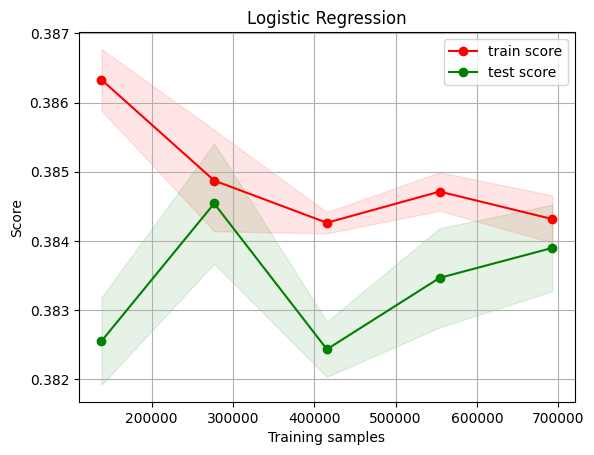

In [ ]:
compute_and_plot_learning_curve(0.30)

###Calibración con todo el conjunto de datos

In [ ]:
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)

In [ ]:
lr.fit(X_pca,y)

LogisticRegression(class_weight='balanced', solver='newton-cholesky')

##Predicción

In [ ]:
test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df_processed = process_data(test_df, programs_df)
print(test_df_processed.shape)
test_df_processed = pca.transform(test_df_processed)

(296786, 20)


/tmp/ipython-input-6-3166745170.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(296786, 57)


In [ ]:
y_pred = lr.predict(test_df_processed)

###Dataframe de predicción

In [ ]:
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
y_pred = pd.DataFrame(y_pred, columns=['RENDIMIENTO_GLOBAL'])
y_pred = y_pred.replace(dict(zip(range(4), grades)))
y_pred.head()
prediction_df = pd.concat([test_df['ID'], y_pred], axis=1).set_index('ID')
print(prediction_df.shape)
prediction_df.head()

(296786, 1)


,RENDIMIENTO_GLOBAL
ID,
550236,bajo
98545,medio-alto
499179,alto
782980,bajo
785185,bajo


###Exportando el archivo

In [ ]:
prediction_df.to_csv("submission.csv")